# NEST Topology User Manual
HUSK DEPRECATED WARINGS

# Introduction
The Topology Module provides the NEST simulator (NEST is
  available under an open source license at
[www.nest-simulator.org](www.nest-simulator.org))
<cite data-cite="Gewa:2007(1430)">(Gewaltig and Diesmann, 2007)</cite> with a convenient interface for creating
layers of neurons placed in space and connecting neurons in such
layers with probabilities and properties depending on the relative
placement of neurons.  This permits the creation of complex networks
with spatial structure.

This user manual provides an introduction to the functionality
provided by the Topology Module. It is based exclusively on the
PyNEST, the Python interface to NEST <cite data-cite="Eppl:2008(12)">(Eppler et al., 2008)</cite>. NEST users
using the SLI interface should be able to map instructions to
corresponding SLI code. This manual is not meant as a comprehensive
reference manual. Please consult the online documentation in PyNEST
for details; where appropriate, that documentation also points to
relevant SLI documentation.

This manual describes the Topology Module included with NEST 2.12; 
the user interface and behaviour of the module has not changed 
significantly since NEST 2.2.

In the next chapter of this manual, we introduce Topology layers,
which place neurons in space. In the chapter 'Connections' we then
describe how to connect layers with each other, before discussing how you can inspect and visualize
Topology networks in
Chapter 'Inspecting layers'. The final chapter deals with the more advanced
topic of extending the Topology module with custom kernel functions and
masks provided by C++ classes in an extension module.

You will find the Python scripts used in the examples in this manual 
 in the NEST
source code directory under `topology/doc/user_manual_scripts`.

## Limitations and Disclaimer
**Undocumented Features:** The Topology Module provides a number of undocumented features, which
you may discover by browsing the code. These features are highly
experimental and should *not be used for simulations*, as they
have not been validated.

# Layers


The Topology Module (just Topology for short in the remainder of this
document) organizes neuronal networks in *layers*. We will first
illustrate how Topology places elements in simple layers, where each
element is a single model neuron. Layers with composite elements are
discussed in the following section.

We will illustrate the definition and use of layers using examples.

Topology distinguishes between two classes of layers:

- **grid-based layers** in which each element is placed at a location in
  a regular grid;
- **free layers** in which elements can be placed arbitrarily in the plane.

Grid-based layers allow for more efficient connection-generation under
certain circumstances.

## Grid-based layers
### A very simple layer
We create a first, grid-based simple layer 
with the following commands:

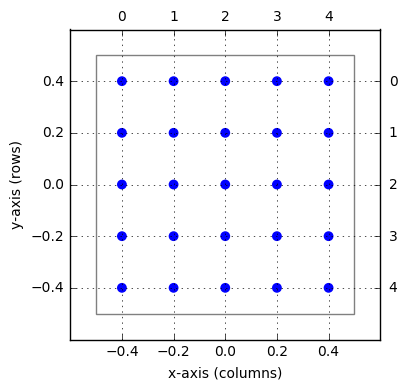

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np

# seed NumPy RNG to ensure identical results for runs with random placement
np.random.seed(1234567)


def beautify_layer(l, fig=plt.gcf(), xlabel=None, ylabel=None,
                   xlim=None, ylim=None, xticks=None, yticks=None, dx=0, dy=0):
    """Assume either x and ylims/ticks given or none"""

    top = nest.GetStatus(l)[0]['topology']
    ctr = top['center']
    ext = top['extent']

    if xticks is None:
        if 'rows' in top:
            dx = float(ext[0]) / top['columns']
            dy = float(ext[1]) / top['rows']
            xticks = ctr[0] - ext[0] / 2. + dx / 2. + dx * np.arange(
                top['columns'])
            yticks = ctr[1] - ext[1] / 2. + dy / 2. + dy * np.arange(
                top['rows'])

    if xlim is None:
        xlim = [ctr[0] - ext[0] / 2. - dx / 2., ctr[0] + ext[
            0] / 2. + dx / 2.]  # extra space so extent is visible
        ylim = [ctr[1] - ext[1] / 2. - dy / 2., ctr[1] + ext[1] / 2. + dy / 2.]
    else:
        ext = [xlim[1] - xlim[0], ylim[1] - ylim[0]]

    ax = fig.gca()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', 'box')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.grid(True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return


# --------------------------------------------------

nest.ResetKernel()

import nest.topology as tp

l = tp.CreateLayer({'rows': 5,
                    'columns': 5,
                    'elements': 'iaf_psc_alpha'})

fig = tp.PlotLayer(l, nodesize=50)
beautify_layer(l, fig, xlabel='x-axis (columns)', ylabel='y-axis (rows)')
ax = fig.gca()
tx = []
for r in range(5):
    tx.append(ax.text(0.65, 0.4 - r * 0.2, str(r),
                      horizontalalignment='center',
                      verticalalignment='center'))
    tx.append(ax.text(-0.4 + r * 0.2, 0.65, str(r),
                      horizontalalignment='center',
                      verticalalignment='center'))

Note the following
properties:

- The layer has five *rows* and five
  *columns*.
- The `elements` entry of the dictionary passed to
  `CreateLayer` determines the
  *elements* of the layer. In this case, the layer
  contains `iaf_psc_alpha` neurons.
- The *centre* of the layer is at the origin of
  the coordinate system, $(0,0)$. 
- The *extent* or size of the layer is $1\times1$. This is the default size for layers. The extent is marked by the
  thin square.
- The *grid spacing* of the layer is
\begin{equation}\begin{split}
dx &= \frac{\text{x-extent}}{\text{number of columns}} \\
dy &= \frac{\text{y-extent}}{\text{number of rows}}. 
\end{split}\end{equation}
In the layer shown, we have $dx=dy=0.2$, but the grid spacing may differ
in x- and y-direction.
- Layer elements are spaced by the grid spacing and are arranged
  symmetrically about the centre. 
- The outermost layer elements are placed $dx/2$ and $dy/2$ from
  the borders of the extent.
- Element *positions* in the coordinate
  system are given by $(x,y)$ pairs. The *coordinate
    system* follows that standard
  mathematical convention that the $x$-axis runs from left to right
  and the $y$-axis from bottom to top.
- Each element of a grid-based layer has a *row- and
    column-index*  in addition to its
  $(x,y)$-coordinates. Indices are shown in the top and right margin. Note that row-indices follow matrix
  convention, i.e., run from top to bottom. Following pythonic
  conventions, indices run from 0. 

### Setting the extent
Layers have a default extent of $1\times 1$. 
You can specify a different extent of a layer, i.e., its size in $x$- and
$y$-direction by adding an `extent` entry to the
dictionary passed to `CreateLayer`:

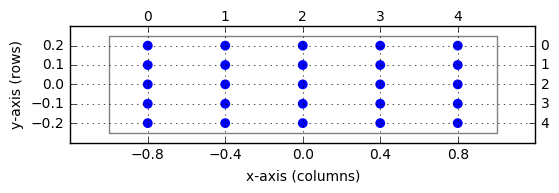

In [2]:
l = tp.CreateLayer({'rows': 5,
                    'columns': 5,
                    'extent': [2.0, 0.5],
                    'elements': 'iaf_psc_alpha'})

fig = tp.PlotLayer(l, nodesize=50)
beautify_layer(l, fig, xlabel='x-axis (columns)', ylabel='y-axis (rows)')
ax = fig.gca()
tx = []

for r in range(5):
    tx.append(fig.gca().text(1.25, 0.2 - r * 0.1, str(r),
                             horizontalalignment='center',
                             verticalalignment='center'))
    tx.append(fig.gca().text(-0.8 + r * 0.4, 0.35, str(r),
                             horizontalalignment='center',
                             verticalalignment='center'))

The extent is always a two-element tuple of floats. In this example, we have grid
spacings $dx=0.4$ and $dy=0.1$. Changing the extent does not affect
grid indices.

### Setting the centre
Layers are centred about the origin $(0,0)$ by default. This can be
changed through the `center` entry in the dictionary
specifying the layer. The following code creates layers centred about
$(0,0)$, $(-1,1)$, and $(1.5,0.5)$, respectively:

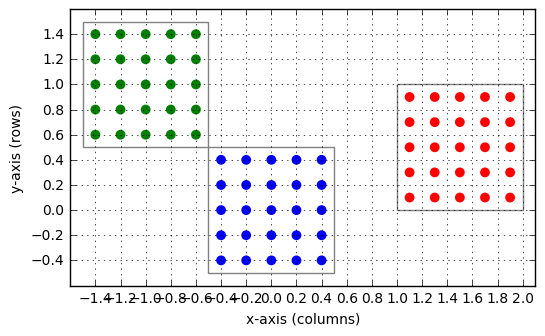

In [3]:
l1 = tp.CreateLayer({'rows': 5, 'columns': 5, 'elements': 'iaf_psc_alpha'})
l2 = tp.CreateLayer({'rows': 5, 'columns': 5, 'elements': 'iaf_psc_alpha',
                     'center': [-1., 1.]})
l3 = tp.CreateLayer({'rows': 5, 'columns': 5, 'elements': 'iaf_psc_alpha',
                     'center': [1.5, 0.5]})

fig = tp.PlotLayer(l1, nodesize=50)
tp.PlotLayer(l2, nodesize=50, nodecolor='g', fig=fig)
tp.PlotLayer(l3, nodesize=50, nodecolor='r', fig=fig)
beautify_layer(l1, fig, xlabel='x-axis (columns)', ylabel='y-axis (rows)',
               xlim=[-1.6, 2.1], ylim=[-0.6, 1.6],
               xticks=np.arange(-1.4, 2.05, 0.2),
               yticks=np.arange(-0.4, 1.45, 0.2))

The centre is given as a two-element tuple of floats.
Changing the centre does not affect grid indices: For each of the
three layers in, grid indices run from 0 to 4
through columns and rows, respectively, even though elements in these
three layers have different positions in the global coordinate system.

### Constructing a layer: an example

To see how to construct a layer, consider the following example: 

- a layer with $n_r$ rows and $n_c$ columns;
- spacing between nodes is $d$ in $x$- and $y$-directions;
- the left edge of the extent shall be at $x=0$;
- the extent shall be centred about $y=0$.

From the equations on grid spacing, we see that the extent of the layer
must be $(n_c d, n_r d)$. We now need to find the coordinates $(c_x, c_y)$ of the centre of the layer. To place the left edge of the extent
at $x=0$, we must place the centre of the layer at $c_x=n_c d / 2$
along the $x$-axis, i.e., half the extent width to the right of
$x=0$. Since the layer is to be centred about $y=0$, we have
$c_y=0$. Thus, the centre coordinates are $(n_c d/2, 0)$. The layer is
created with the following code:

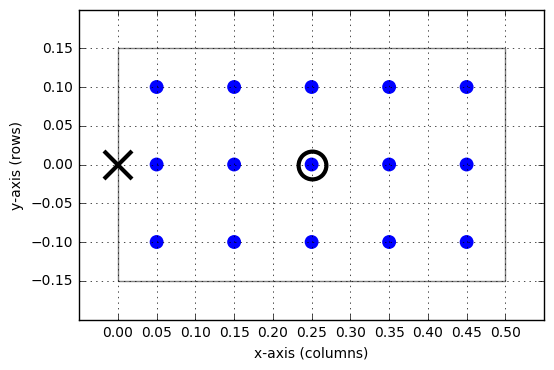

In [4]:
nc, nr = 5, 3
d = 0.1
l = tp.CreateLayer({'columns': nc, 'rows': nr, 'elements': 'iaf_psc_alpha',
                    'extent': [nc * d, nr * d], 'center': [nc * d / 2., 0.]})

fig = tp.PlotLayer(l, nodesize=100)
plt.plot(0, 0, 'x', markersize=20, c='k', mew=3)
plt.plot(nc * d / 2, 0, 'o', markersize=20, c='k', mew=3, mfc='none',
         zorder=100)
beautify_layer(l, fig, xlabel='x-axis (columns)', ylabel='y-axis (rows)',
               xticks=np.arange(0., 0.501, 0.05),
               yticks=np.arange(-0.15, 0.151, 0.05),
               xlim=[-0.05, 0.55], ylim=[-0.2, 0.2])

## Free Layers
**Free Layers** do not restrict node positions to
a grid, but allow free placement within the extent. To this end, the
user needs to specify the positions of all nodes explicitly. The
following code creates a layer of 50 `iaf_psc_alpha` neurons uniformly
distributed in a layer with extent $1\times 1$, i.e., spanning the
square $[-0.5,0.5]\times[-0.5,0.5]$:

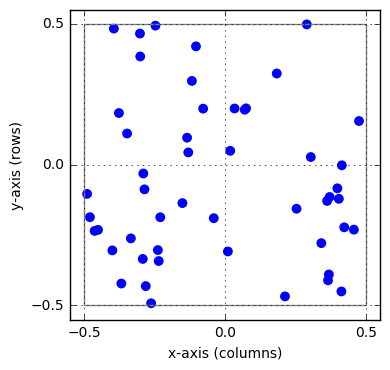

In [5]:
nest.ResetKernel()
pos = [[np.random.uniform(-0.5, 0.5), np.random.uniform(-0.5, 0.5)]
       for j in range(50)]
lf = tp.CreateLayer({'positions': pos,
                    'elements': 'iaf_psc_alpha'})

fig = tp.PlotLayer(lf, nodesize=50)
beautify_layer(lf, fig, xlabel='x-axis (columns)', ylabel='y-axis (rows)',
               xlim=[-0.55, 0.55], ylim=[-0.55, 0.55],
               xticks=[-0.5, 0., 0.5], yticks=[-0.5, 0., 0.5])

Note the following points:

- For free layers, element *positions* are
  specified by the `positions` entry in the dictionary
  passed to `CreateLayer`. `positions` is
  mutually exclusive with `rows`/`columns`
  entries in the dictionary.
- The `positions` entry must be a Python
  `list` (or `tuple`) of element coordinates,
  i.e., of two-element tuples of floats giving the ($x$, $y$)-coordinates
  of the elements. One layer element is created per element in the
  `positions` entry.
- All layer element positions must be *within* the layer's
  extent. Elements may be placed on the perimeter of the extent as long
  as no periodic boundary conditions are used; see the section 'Periodic boundary conditions' below.
- Element positions in free layers are *not* shifted when
  specifying the `centre` of the layer. The user must make
  sure that the positions given lie within the extent when centred
  about the given centre.

## 3D layers
Although the term "layer" suggests a 2-dimensional structure, the layers
in NEST may in fact be 3-dimensional.  The example from
the previous section may be easily extended with another component in the
coordinates for the positions:

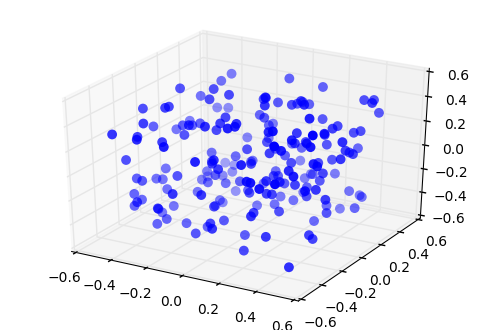

In [6]:
pos = [[np.random.uniform(-0.5, 0.5), np.random.uniform(-0.5, 0.5),
        np.random.uniform(-0.5, 0.5)] for j in range(200)]
l3d = tp.CreateLayer({'positions': pos,
                    'elements': 'iaf_psc_alpha'})

fig = tp.PlotLayer(l3d, nodesize=50)

## Periodic boundary conditions
Simulations usually model systems much smaller than the biological
networks we want to study. One problem this entails is that a
significant proportion of neurons in a model network is close to the
edges of the network with fewer neighbours than nodes properly inside
the network. In the $5\times 5$-layer in the first grid-based layer we looked at, e.g., 16 out of 25 nodes form the border of the layer.

One common approach to reducing the effect of boundaries on
simulations is to introduce *periodic boundary conditions*, so that the
rightmost elements on a grid are considered nearest neighbours to the
leftmost elements, and the topmost to the bottommost. The flat layer
becomes the surface of a torus. The figure below illustrates this
for a one-dimensional layer, which turns from a line to a ring upon
introduction of periodic boundary conditions. 

<table class="image">
<caption align="bottom">Top left: Layer with single row and five columns without periodic
  boundary conditions. Numbers above elements
  show element coordinates. Colours shifting from blue to magenta mark
  increasing distance from the element at $(-2,0)$. 
  Bottom left: Same layer, but with periodic boundary
  conditions.
  Note that the element at $(2,0)$ now is a nearest
  neighbour to the element at $(-2,0)$.
  Right: Layer with periodic boundary condition arranged on a circle
  to illustrate neighbourhood relationships.</caption>
<tr><td><img src="user_manual_figures/player.png" alt="Periodic boundary conditions" style="width: 500px;"/></td></tr>
</table>

You specify periodic boundary conditions for a layer using the
dictionary entry `edge_wrap`:

In [7]:
lp = tp.CreateLayer({'rows': 1, 'columns': 5, 'extent': [5., 1.],
                     'elements': 'iaf_psc_alpha',
                     'edge_wrap': True})

Note that the longest possible distance between two elements in a
layer without periodic boundary conditions is
\begin{equation*}
\sqrt{x_{\text{ext}}^2 + y_{\text{ext}}^2}
\end{equation*}
but only
\begin{equation*}
\left.\sqrt{x_{\text{ext}}^2 + y_{\text{ext}}^2}\right/ 2
\end{equation*}
for a layer with periodic boundary conditions; $x_{\text{ext}}$ and
$y_{\text{ext}}$ are the components of the extent size. 

We will discuss the consequences of periodic boundary conditions more
in the chapter 'Connections'.

### Topology layer as NEST subnet

From the perspective of NEST, a Topology layer is a special type of
*subnet*. From the user perspective, the following
points may be of interest:

- Grid-based layers have the NEST model type
  `topology_layer_grid`, free
  layers the model type
  `topology_layer_free`.
- The status dictionary of a layer has a `topology`
  entry describing the layer properties (see example using `nest.GetStatus` below). The `topology` entry is read-only.
- The NEST kernel sees the elements of the layer in the same way
  as the elements of any subnet. You will notice this when printing a
  network with a Topology layer (see `nest.PrintNetwork` example below). The $5\times 5$ layer created appears here as a `topology_layer_grid` subnet of 25 `iaf_psc_alpha` neurons. Only Topology connection and visualization functions heed the spatial structure of the layer.

In [8]:
nest.ResetKernel()
l = tp.CreateLayer({'rows': 5, 'columns': 5, 'elements': 'iaf_psc_alpha'})
print(nest.GetStatus(l)[0]['topology'])

{u'rows': 5, u'center': (0.0, 0.0), u'edge_wrap': False, u'depth': 1, u'extent': (1.0, 1.0), u'columns': 5}


In [9]:
nest.PrintNetwork(depth=3)

Output from this function will be in the terminal, and you should get
```
+-[0] root dim=[1 25]
   |
   +-[1] topology_layer_grid dim=[25]
      |
      +-[1]...[25] iaf_psc_alpha

```

## Layers with composite elements
So far, we have considered layers in which each element was a single
model neuron. Topology can also create layers with *composite
  elements*, i.e., layers in which each
element is a collection of model neurons, or, in
general NEST network nodes.

Construction of layers with composite elements proceeds exactly as for
layers with simple elements, except that the `elements`
entry of the dictionary passed to `CreateLayer` is a Python
list or tuple. The following code creates a $1\times 2$ layer (to keep
the output from ```PrintNetwork()```compact) in which
each element consists of one `iaf_cond_alpha` and one
`poisson_generator` node

In [10]:
l = tp.CreateLayer({'rows': 1, 'columns': 2,
                    'elements': ['iaf_cond_alpha', 'poisson_generator']})

The network consist of one `topology_layer_grid` with four
elements: two `iaf_cond_alpha` and two
`poisson_generator` nodes. The identical nodes are grouped, so
that the subnet contains first one full layer of `iaf_cond_alpha`
nodes followed by one full layer of `poisson_generator` nodes.

You can create network elements with several nodes of each type by
following a model name with the number of nodes to be created:

In [11]:
l = tp.CreateLayer({'rows': 1, 'columns': 2,
                    'elements': ['iaf_cond_alpha', 10, 'poisson_generator',
                                 'noise_generator', 2]})

In this case, each layer element consists of 10
`iaf_cond_alpha` neurons, one `poisson_generator`,
and two `noise_generator`s. 

Note the following points:

- Each element of a layer has identical components.
- All nodes within a composite element have identical positions,
  namely the position of the layer element.
- When inspecting a layer as a subnet, the different nodes will appear
  in groups of identical nodes.
- For grid-based layers, the function `GetElement` returns a
  list of nodes at a given grid position. We will look closer at inspecting layers later.
- In a previous version of the topology module it was possible to
  create layers with nested, composite elements, but such nested networks
  gobble up a lot of memory for subnet constructs and provide no practical
  advantages, so this is no longer supported. See the next section for
  design recommendations for more complex layers.


### Designing layers

A paper on a neural network model might describe the network as
follows (see <cite data-cite="Nord:2009(456)">Nordlie et al. (2009)</cite> for suggestions on how to
  describe network models):

>The network consists of $20x20$ microcolumns placed on a regular grid
>spanning $0.5^\circ\times 0.5^\circ$ of visual space. Neurons within each
>microcolumn are organized into L2/3, L4, and L56
>subpopulations. Each subpopulation consists of three pyramidal cells
>and one interneuron. All pyramidal cells are modelled as NEST
>`iaf_psc_alpha` neurons with default parameter values, while
>interneurons are `iaf_psc_alpha` neurons with threshold voltage
>$V_{\text{th}}=-52$mV. 

How should you implement such a network using the Topology module?
The recommended approach is to create different models for the
neurons in each layer and then define the microcolumn as one
composite element:

In [12]:
for lyr in ['L23', 'L4', 'L56']:
    nest.CopyModel('iaf_psc_alpha', lyr + 'pyr')
    nest.CopyModel('iaf_psc_alpha', lyr + 'in', {'V_th': -52.})
l = tp.CreateLayer({'rows': 20, 'columns': 20, 'extent': [0.5, 0.5],
                    'elements': ['L23pyr', 3, 'L23in',
                                 'L4pyr', 3, 'L4in',
                                 'L56pyr', 3, 'L56in']})

We will discuss in the next chapter how to connect
selectively to different neuron models.


# Connections

The most important feature of the Topology module is the ability to
create connections between layers with quite some
flexibility. In this chapter, we will illustrate how to specify and
create connections. All connections are created using the
`ConnectLayers` function.


## Basic principles

### Terminology
We begin by introducing important terminology:

- **Connection**: In the context of connections
  between the elements of Topology layers, we often call the set of all connections
  between pairs of network nodes created by a single call to
  `ConnectLayers` a *connection*.
- **Connection dictionary**:  A dictionary
  specifying the properties of a connection between two layers in a call to
  `CreateLayers`.
- **Source**: The *source* of a single connection
  is the node sending signals (usually spikes). In a projection, the
  source layer is the layer from which source nodes
  are chosen.
- **Target**: The *target* of a single connection
  is the node receiving signals (usually spikes). In a projection, the
  target layer is the layer from which target nodes
  are chosen.
- **Connection type**: The *connection type* determines how nodes are selected when
  `ConnectLayers` creates connections between layers. It is
  either `convergent` or `divergent`.
- **Convergent connection**:  When creating a *convergent connection* between layers, Topology
  visits each node in the target layer in turn and selects sources for
  it in the source layer. Masks and kernels are applied to the source
  layer, and periodic boundary conditions are applied in the source
  layer, provided that the source layer has periodic boundary conditions.
- **Divergent connection**:  When creating a *divergent connection*, Topology visits each node in the
  source layer and selects target nodes from the target layer. Masks, kernels, and
  boundary conditions are applied in the target layer.
- **Driver**:  When connecting two layers, the
  *driver* layer is the one in which each node is considered in
  turn. 
- **Pool**: When connecting two layers, the
  *pool* layer is the one from which nodes are chosen for each
  node in the driver layer. I.e., we have

<table style="border:hidden">
  <tr>
    <th style="border-right:double;border-bottom:double">Connection type</th>
    <th style="border-bottom:double">Driver</th>
    <th style="border-bottom:double">Pool</th>
  </tr>
  <tr>
    <td style="border-right:double">convergent</td>
    <td>target layer</td>
    <td>source layer</td>
  </tr>
  <tr>
    <td style="border-right:double">divergent</td>
    <td>source layer</td>
    <td>target layer</td>
  </tr>
  </table>

- **Displacement**: The *displacement*
  between a driver and a pool node is the shortest vector connecting
  the driver to the pool node, taking
  boundary conditions into account.
- **Distance**: The *distance* between a driver
  and a pool node is the length of their displacement.
- **Mask**: The *mask* defines which pool nodes are
  at all considered as potential targets for each driver node. See
  the Masks section for details.
- **Kernel**: The *kernel* is a function returning
  a (possibly distance- or displacement-dependent) 
  probability for creating a connection between a driver and a pool
  node. The default kernel is $1$, i.e., connections are created with
  certainty. See the Kernel section for details.
- **Autapse**: An *autapse* is a synapse (connection) from a
  node onto itself. Autapses are permitted by default, but can be
  disabled by adding `'allow_autapses': False`to the
  connection dictionary.
- **Multapse**: Node A is connected to node B by a
  *multapse* if there are synapses (connections) from A to
  B. Multapses are permitted by default, but can be disabled by adding
  `'allow_multapses': False`to the connection dictionary.

### A minimal ConnectLayers call
Connections between Topology layers are created by calling
`ConnectLayers` with the following arguments (You
  can also use standard NEST connection functions to connect nodes in
  Topology layers.):

- The source layer.
- The target layer (can be identical to source layer).
- A connection dictionary that contains at least the following entry:
  * `connection_type`: either `convergent` or `divergent`.

In many cases, the connection dictionary will also contain

`mask`: a mask specification as described the Masks section.

Only neurons within the mask are considered as potential sources or
targets. If no mask is given, all neurons in the respective layer
are considered sources or targets.

Here is a simple example:

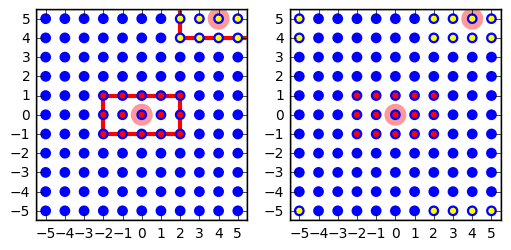

In [13]:
nest.ResetKernel()


def conn_figure(fig, layer, connd, targets=None, showmask=True, showkern=False,
                xticks=range(-5, 6), yticks=range(-5, 6),
                xlim=[-5.5, 5.5], ylim=[-5.5, 5.5]):
    if targets is None:
        targets = ((tp.FindCenterElement(layer), 'red'),)

    tp.PlotLayer(layer, fig=fig, nodesize=60)
    for src, clr in targets:
        if showmask:
            mask = connd['mask']
        else:
            mask = None
        if showkern:
            kern = connd['kernel']
        else:
            kern = None
        tp.PlotTargets(src, layer, fig=fig, mask=mask, kernel=kern,
                       src_size=250, tgt_color=clr, tgt_size=20,
                       kernel_color='green')

    beautify_layer(layer, fig,
                   xlim=xlim, ylim=ylim, xticks=xticks, yticks=yticks,
                   xlabel='', ylabel='')
    fig.gca().grid(False)
    
# -----------------------------------------------

l = tp.CreateLayer({'rows': 11, 'columns': 11, 'extent': [11., 11.],
                    'elements': 'iaf_psc_alpha'})
conndict = {'connection_type': 'divergent',
            'mask': {'rectangular': {'lower_left': [-2., -1.],
                                     'upper_right': [2., 1.]}}}
tp.ConnectLayers(l, l, conndict)

fig = plt.figure()
fig.add_subplot(121)
conn_figure(fig, l, conndict,
            targets=((tp.FindCenterElement(l), 'red'),
                     (tp.FindNearestElement(l, [4., 5.]), 'yellow')))

# same another time, with periodic bcs
lpbc = tp.CreateLayer({'rows': 11, 'columns': 11, 'extent': [11., 11.],
                       'elements': 'iaf_psc_alpha', 'edge_wrap': True})
tp.ConnectLayers(lpbc, lpbc, conndict)
fig.add_subplot(122)
conn_figure(fig, lpbc, conndict, showmask=False,
            targets=((tp.FindCenterElement(lpbc), 'red'),
                     (tp.FindNearestElement(lpbc, [4., 5.]), 'yellow')))

In this example, layer `l` is both source and target
layer. Connection type is divergent, i.e., for each node in the layer
we choose targets according to the rectangular mask centred about
each source node. Since no connection kernel is specified, we connect
to all nodes within the mask. Note the effect of normal and periodic
boundary conditions on the connections created for different nodes in
the layer, as illustrated in the resulting figures.

The resulting figure on the left shows a minimal connection example from a layer onto itself using a rectangular mask shown as red line for the node at $(0,0)$ (marked light red). The targets of this node are marked with red dots. The targets for the node at $(4,5)$ are marked with yellow dots. This node has fewer targets since it is at the corner and many potential targets are beyond the layer. On the right figure we see the effect of periodic boundary conditions. Source and target layer and connection dictionary are identical, except that periodic boundary conditions are
used. The node at $(4,5)$ now has 15 targets, too, but they are spread
across the corners of the layer. If we wrapped the layer to a torus,
they would form a $5\times 3$ rectangle centred on the node at $(4,5)$.


## Mapping source and target layers

The application of masks and other functions depending on the distance
or even the displacement between nodes in the source and target layers
requires a mapping of coordinate
systems between source and target
layers. Topology applies the following *coordinate mapping rules*:

1. All layers have two-dimensional Euclidean coordinate systems.
2. No scaling or coordinate transformation can be applied between
   layers.
3. The displacement $d(D,P)$ from node $D$ in the driver layer to node $P$
   in the pool layer is measured by first mapping the position of $D$
   in the driver layer to the identical position in the pool layer and
   then computing the displacement from that position to $P$. If the
   pool layer has periodic boundary conditions, they are taken into
   account. It does not matter for displacement computations whether
   the driver layer has periodic boundary conditions.

## Masks

A mask describes which area of the pool layer shall be searched for
nodes to connect for any given node in the driver layer. We will first
describe geometrical masks defined for all layer types and then
consider grid-based masks for grid-based layers. If no mask is
specified, all nodes in the pool layer will be searched.

Note that the mask size should not exceed the size of the layer when
using periodic boundary conditions, since the mask would "wrap
around" in that case and pool nodes would be considered multiple
times as targets.

If none of the mask types provided in the topology library meet your need,
you may add more mask types in a NEST extension module. This will be covered further down.


### Masks for 2D layers

Topology currently provides three types of masks usable for 2-dimensional
free and grid-based layers. The masks are

- **Rectangular**: All nodes within a rectangular
  area are connected. The area is specified by its lower left and
  upper right corners, measured in the same unit as element
  coordinates.
- **Circular**: All nodes within a circle are
  connected.  The area is specified by its radius.
- **Doughnut**: All nodes between an inner and outer
  circle are connected. Note that nodes *on* the inner circle are
  not connected. The area is specified by the radii of the inner and
  outer circles.

By default, the masks are centred about the position of the driver
node, mapped into the pool layer. You can change the location of the
mask relative to the driver node by specifying an
`anchor` entry in the mask dictionary. The
anchor is a 2D vector specifying the location of the mask centre
relative to the driver node.

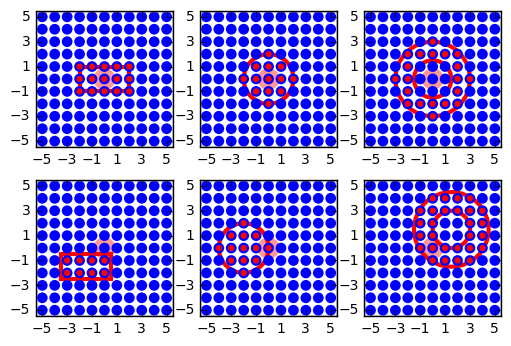

In [14]:
def free_mask_fig(fig, loc, cdict):
    nest.ResetKernel()
    l = tp.CreateLayer({'rows': 11, 'columns': 11, 'extent': [11., 11.],
                        'elements': 'iaf_psc_alpha'})
    tp.ConnectLayers(l, l, cdict)

    fig.add_subplot(loc)
    conn_figure(fig, l, cdict, xticks=range(-5, 6, 2), yticks=range(-5, 6, 2))


fig = plt.figure()

# rectangular mask
conndict = {'connection_type': 'divergent',
            'mask': {'rectangular': {'lower_left': [-2., -1.],
                                     'upper_right': [2., 1.]}}}
free_mask_fig(fig, 231, conndict)

# circular mask
conndict = {'connection_type': 'divergent',
            'mask': {'circular': {'radius': 2.0}}}
free_mask_fig(fig, 232, conndict)

# doughnut mask
conndict = {'connection_type': 'divergent',
            'mask': {'doughnut': {'inner_radius': 1.5,
                                  'outer_radius': 3.}}}
free_mask_fig(fig, 233, conndict)

# rectangular mask with anchor
conndict = {'connection_type': 'divergent',
            'mask': {'rectangular': {'lower_left': [-2., -1.],
                                     'upper_right': [2., 1.]},
                     'anchor': [-1.5, -1.5]}}
free_mask_fig(fig, 234, conndict)

# circular mask with anchor
conndict = {'connection_type': 'divergent',
            'mask': {'circular': {'radius': 2.0},
                     'anchor': [-2.0, 0.0]}}
free_mask_fig(fig, 235, conndict)

# doughnut mask with anchor
conndict = {'connection_type': 'divergent',
            'mask': {'doughnut': {'inner_radius': 1.5,
                                  'outer_radius': 3.},
                     'anchor': [1.5, 1.5]}}
free_mask_fig(fig, 236, conndict)

### Masks for 3D layers
Similarly, there are two mask types that can be used for 3D layers,

-  **Box**: All nodes within a cuboid volume are connected. The
   area is specified by its lower left and upper right corners, measured in
   the same unit as element coordinates.
-  **Spherical**: All nodes within a sphere are
   connected.  The area is specified by its radius.

As in the 2D case, you can change the location of the mask relative to the
driver node by specifying a 3D vector in the
`anchor` entry in the mask dictionary.

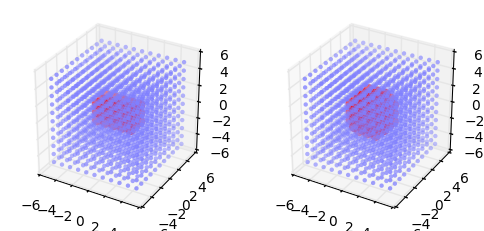

In [15]:
def conn_figure_3d(fig, layer, connd, targets=None, showmask=True,
                   showkern=False,
                   xticks=range(-5, 6), yticks=range(-5, 6),
                   xlim=[-5.5, 5.5], ylim=[-5.5, 5.5]):
    if targets is None:
        targets = ((tp.FindCenterElement(layer), 'red'),)

    tp.PlotLayer(layer, fig=fig, nodesize=10, nodecolor=(.5, .5, 1.))
    for src, clr in targets:
        if showmask:
            mask = connd['mask']
        else:
            mask = None
        if showkern:
            kern = connd['kernel']
        else:
            kern = None
        tp.PlotTargets(src, layer, fig=fig, mask=mask, kernel=kern,
                       src_size=250, tgt_color=clr, tgt_size=60,
                       kernel_color='green')

    ax = fig.gca()
    ax.set_aspect('equal', 'box')
    plt.draw()


def free_mask_3d_fig(fig, loc, cdict):
    nest.ResetKernel()
    l = tp.CreateLayer(
        {'rows': 11, 'columns': 11, 'layers': 11, 'extent': [11., 11., 11.],
         'elements': 'iaf_psc_alpha'})
    tp.ConnectLayers(l, l, cdict)

    fig.add_subplot(loc, projection='3d')
    conn_figure_3d(fig, l, cdict, xticks=range(-5, 6, 2),
                   yticks=range(-5, 6, 2))

fig = plt.figure()

# box mask
conndict = {'connection_type': 'divergent',
            'mask': {'box': {'lower_left': [-2., -1., -1.],
                             'upper_right': [2., 1., 1.]}}}
free_mask_3d_fig(fig, 121, conndict)

# spherical mask
conndict = {'connection_type': 'divergent',
            'mask': {'spherical': {'radius': 2.5}}}
free_mask_3d_fig(fig, 122, conndict)

### Masks for grid-based layers
Grid-based layers can be connected using rectangular *grid
  masks*. For these, you specify the size of the mask
not by lower left and upper right corner coordinates, but give their
size in rows and columns, as in this example:

In [16]:
def grid_mask_fig(fig, loc, cdict):
    nest.ResetKernel()
    l = tp.CreateLayer({'rows': 11, 'columns': 11, 'extent': [11., 11.],
                        'elements': 'iaf_psc_alpha'})
    tp.ConnectLayers(l, l, cdict)

    fig.add_subplot(loc)
    conn_figure(fig, l, cdict, xticks=range(-5, 6, 2), yticks=range(-5, 6, 2),
                showmask=False)


conndict_1 = {'connection_type': 'divergent',
            'mask': {'grid': {'rows': 3, 'columns': 5}}}

The resulting connections are shown below. By
default the top-left corner of a grid mask, i.e., the grid mask
element with grid index $[0,0]$ (see the section on Grid-based Layers for the
distinction between layer coordinates and grid indices), is aligned
with the driver node. You can change this alignment by specifying an 
 *anchor* for the mask:

In [17]:
conndict_2 = {'connection_type': 'divergent',
            'mask': {'grid': {'rows': 3, 'columns': 5},
                     'anchor': {'row': 1, 'column': 2}}}

You can even place the anchor outside the mask:

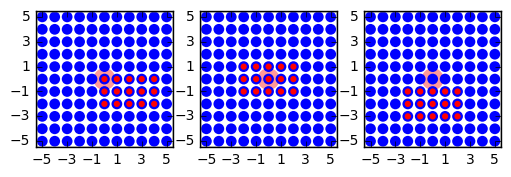

In [18]:
conndict_3 = {'connection_type': 'divergent',
            'mask': {'grid': {'rows': 3, 'columns': 5},
                     'anchor': {'row': -1, 'column': 2}}}
fig = plt.figure()
grid_mask_fig(fig, 131, conndict_1)
grid_mask_fig(fig, 132, conndict_2)
grid_mask_fig(fig, 133, conndict_3)

Connections specified using grid masks are generated more efficiently than connections specified using other mask types. 

Note the following:

- Grid-based masks are applied by considering grid indices. The
  position of nodes in physical coordinates is ignored.
- In consequence, grid-based masks should only be used between
  layers with identical grid spacings. 
- The semantics of the `anchor` property for
  grid-based masks differ
  significantly for general masks described earlier. For general masks, the anchor is the centre
  of the mask relative to the driver node. For grid-based nodes, the
  anchor determines which mask element is aligned with the driver element.

## Kernels

Many neuronal network models employ probabilistic connection
rules. Topology supports
probabilistic connections through *kernels*. A
kernel is a function mapping the distance (or displacement) between a
driver and a pool node to a connection probability. Topology then
generates a connection according to this probability.

Probabilistic connections can be generated in two different ways using
Topology:

- **Free probabilistic connections** are the default. 
  In this case, `ConnectLayers` considers each driver node $D$
  in turn. For each $D$, it evaluates the kernel for each
  pool node $P$ within the mask and creates a connection according to
  the resulting probability. This means in particular that *each
    possible driver-pool pair is inspected exactly once* and that
  there will be *at most one connection between each driver-pool pair*.
- **Prescribed number of connections** can be obtained by specifying
  the number of connections to create per driver node. See the section on Prescribed number of connections for details.

Available kernel functions are shown in the table below. More
kernel function may be created in a NEST extension module. We will cover this further down.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class= style="border:hidden">Name</th>
    <th class= style="border:hidden">Parameters</th>
    <th class="tg-yw4l" style="padding-right: 20em">Function</th>
  </tr>
  <tr>
    <td class= style="border:hidden">constant</td>
    <td class= style="border:hidden"></td>
    <td class="tg-yw4l" style="border:hidden">constant $p\in[0,1]$</td>
  </tr>
  <tr>
    <td class= style="border:hidden">linear<br></td>
    <td class= style="border:hidden">a, c<br></td>
    <td class="tg-yw4l" style="border:hidden">\begin{equation*}p(d) = c + a d\end{equation*}</td>
  </tr>
  <tr>
    <td class= style="border:hidden">exponential</td>
    <td class= style="border:hidden">a, c, tau<br></td>
    <td class="tg-yw4l" style="border:hidden">\begin{equation*}p(d) = c + a e^{-\frac{d}{\tau}}\end{equation*}</td>
  </tr>
  <tr>
    <td class= style="border:hidden">gaussian</td>
    <td class= style="border:hidden">p_center, sigma, mean, c<br></td>
    <td class="tg-yw4l" style="border:hidden">\begin{equation*}p(d) = c + p_{\text{center}},e^{-\frac{(d-\mu)^2}{2\sigma^2}}\end{equation*}</td>
  </tr>
  <tr>
    <td class="tg-xha5" style="border-bottom:double">gaussian2D</td>
    <td class="tg-xha5" style="border-bottom:double">p_center, sigma_x, sigma_y,<br> mean_x, mean_y, rho, c</td>
    <td class="tg-4hfa" style="border-bottom:double">\begin{equation*}p(d) = c + p_{\text{center}}e^{-\frac{\frac{(d_x-\mu_x)^2}{\sigma_x^2}-\frac{(d_y-\mu_y)^2}{\sigma_y^2},+2\rho\frac{(d_x-\mu_x)(d_y-\mu_y)}{\sigma_x\sigma_y}}{2(1-\rho^2)}}\end{equation*}</td>
  </tr>
  <tr>
    <td class="tg-yw4l" style="border:hidden">uniform</td>
    <td class="tg-yw4l" style="border:hidden">**min**, **max**<br></td>
    <td class="tg-yw4l" style="border:hidden">$p\in[\text{min},\text{max})$ uniformly</td>
  </tr>
  <tr>
    <td class="tg-yw4l" style="border:hidden">normal</td>
    <td class="tg-yw4l" style="border:hidden">mean, sigma, **min**, **max**</td>
    <td class="tg-yw4l" style="border:hidden">$p \in [\text{min},\text{max})$ normal with given mean and $\sigma$</td>
  </tr>
  <tr>
    <td class="tg-yw4l" style="border:hidden">lognormal</td>
    <td class="tg-yw4l" style="border:hidden">mu, sigma, **min**, **max**</td>
    <td class="tg-yw4l" style="border:hidden">$p \in [\text{min},\text{max})$ lognormal with given $\mu$ and $\sigma$</td>
  </tr>
</table>

Some examples:

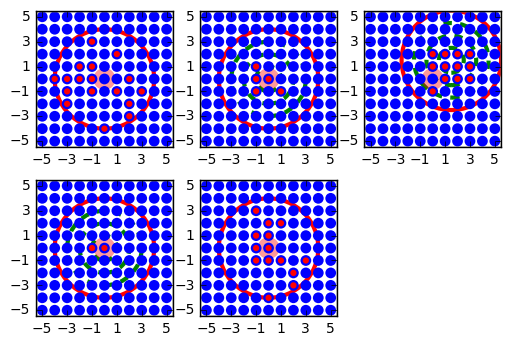

In [19]:
def kernel_fig(fig, loc, cdict, showkern=True):
    nest.ResetKernel()
    l = tp.CreateLayer({'rows': 11, 'columns': 11, 'extent': [11., 11.],
                        'elements': 'iaf_psc_alpha'})
    tp.ConnectLayers(l, l, cdict)

    fig.add_subplot(loc)
    conn_figure(fig, l, cdict, xticks=range(-5, 6, 2), yticks=range(-5, 6, 2),
                showkern=showkern)


fig = plt.figure()

# The simplest kernel is a fixed connection probability:
conndict = {'connection_type': 'divergent',
            'mask': {'circular': {'radius': 4.}},
            'kernel': 0.5}
kernel_fig(fig, 231, conndict)


# This kernel is distance dependent. In the example,
# connection probability is 1 for d=0 and falls off with a
# "standard deviation" of sigma:
conndict = {'connection_type': 'divergent',
            'mask': {'circular': {'radius': 4.}},
            'kernel': {'gaussian': {'p_center': 1.0, 'sigma': 1.}}}
kernel_fig(fig, 232, conndict)

# In this example, both kernel and mask have been moved using anchors:
conndict = {'connection_type': 'divergent',
            'mask': {'circular': {'radius': 4.}, 'anchor': [1.5, 1.5]},
            'kernel': {'gaussian': {'p_center': 1.0, 'sigma': 1.,
                                    'anchor': [1.5, 1.5]}}}
kernel_fig(fig, 233, conndict)

#plt.draw()

# In this example, all probabilities less than 0.5 are set to zero:
conndict = {'connection_type': 'divergent',
            'mask': {'circular': {'radius': 4.}},
            'kernel': {'gaussian': {'p_center': 1.0, 'sigma': 1.,
                                    'cutoff': 0.5}}}
kernel_fig(fig, 234, conndict)

# We conclude with an example using a two-dimensional Gaussian, i.e.,
# a Gaussian with different widths in x- and y-directions. This kernel 
# depends on displacement, not only on distance:
conndict = {'connection_type': 'divergent',
            'mask': {'circular': {'radius': 4.}},
            'kernel': {'gaussian2D': {'p_center': 1.0,
                                      'sigma_x': 1., 'sigma_y': 3.}}}
kernel_fig(fig, 235, conndict, showkern=False)


The resulting figures shown above show illustrations of various kernel functions. Top left: constant kernel,
  $p=0.5$. Top centre: Gaussian kernel, green dashed lines show
  $\sigma$, $2\sigma$, $3\sigma$. Top right: Same Gaussian kernel
  anchored at $(1.5,1.5)$. Bottom left: Same Gaussian kernel, but all
  $p<0.5$ treated as $p=0$. Bottom centre: 2D-Gaussian.

## Weights and delays
The functions presented in the above table can also be used to
specify distance-dependent or randomized weights and delays for the connections created by `ConnectLayers`.

The following examples use weights and delays generated using
these functions. All examples use a
"layer" of 51 nodes placed on a line; the line is centred about
$(25,0)$, so that the leftmost node has coordinates $(0,0)$. The distance between
neighbouring elements is 1. The mask is rectangular, spans the
entire layer and is centred about the driver node.

/home/hakon/Work/NEST/bld_topology_notebook/install/lib/python2.7/site-packages/nest/lib/hl_api_helper.py:91: UserWarning: 
GetLeaves is deprecated and will be removed in NEST 3.0. Use GIDCollection instead.


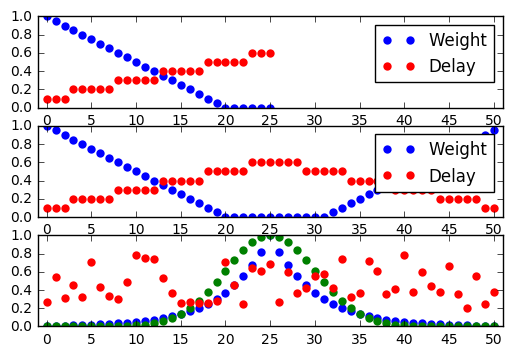

In [20]:
def wd_fig(fig, loc, ldict, cdict, what, rpos=None,
           xlim=[-1, 51], ylim=[0, 1], xticks=range(0, 51, 5),
           yticks=np.arange(0., 1.1, 0.2), clr='blue',
           label=''):
    nest.ResetKernel()
    l = tp.CreateLayer(ldict)
    tp.ConnectLayers(l, l, cdict)

    ax = fig.add_subplot(loc)

    if rpos is None:
        rn = nest.GetLeaves(l)[0][:1]  # first node
    else:
        rn = tp.FindNearestElement(l, rpos)

    conns = nest.GetConnections(rn)
    cstat = nest.GetStatus(conns)
    vals = np.array([sd[what] for sd in cstat])
    tgts = [sd['target'] for sd in cstat]
    locs = np.array(tp.GetPosition(tgts))
    ax.plot(locs[:, 0], vals, 'o', mec='none', mfc=clr, label=label)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)


fig = plt.figure()

# Linear example:
ldict = {'rows': 1, 'columns': 51,
         'extent': [51., 1.], 'center': [25., 0.],
         'elements': 'iaf_psc_alpha'}
cdict = {'connection_type': 'divergent',
         'mask': {'rectangular': {'lower_left': [-25.5, -0.5],
                                  'upper_right': [25.5, 0.5]}},
         'weights': {'linear': {'c': 1.0, 'a': -0.05, 'cutoff': 0.0}},
         'delays': {'linear': {'c': 0.1, 'a': 0.02}}}

wd_fig(fig, 311, ldict, cdict, 'weight', label='Weight')
wd_fig(fig, 311, ldict, cdict, 'delay', label='Delay', clr='red')
fig.gca().legend()

# Linear example with periodic boundary conditions:
# This example is identical to the previous, except that the (pool) layer 
# has periodic boundary conditions. Therefore, the left half of the mask 
# about the node at (0,0) wraps back to the right half of the layer and 
# that node connects to all nodes in the layer.
lpdict = {'rows': 1, 'columns': 51, 'extent': [51., 1.], 'center': [25., 0.],
          'elements': 'iaf_psc_alpha', 'edge_wrap': True}
cdict = {'connection_type': 'divergent',
         'mask': {'rectangular': {'lower_left': [-25.5, -0.5],
                                  'upper_right': [25.5, 0.5]}},
         'weights': {'linear': {'c': 1.0, 'a': -0.05, 'cutoff': 0.0}},
         'delays': {'linear': {'c': 0.1, 'a': 0.02}}}
wd_fig(fig, 312, lpdict, cdict, 'weight', label='Weight')
wd_fig(fig, 312, lpdict, cdict, 'delay', label='Delay', clr='red')
fig.gca().legend()

# Various functions
cdict = {'connection_type': 'divergent',
         'mask': {'rectangular': {'lower_left': [-25.5, -0.5],
                                  'upper_right': [25.5, 0.5]}},
         'weights': {'exponential': {'a': 1., 'tau': 5.}}}
wd_fig(fig, 313, ldict, cdict, 'weight', label='Exponential',
       rpos=[25., 0.])

cdict = {'connection_type': 'divergent',
         'mask': {'rectangular': {'lower_left': [-25.5, -0.5],
                                  'upper_right': [25.5, 0.5]}},
         'weights': {'gaussian': {'p_center': 1., 'sigma': 5.}}}
wd_fig(fig, 313, ldict, cdict, 'weight', label='Gaussian', clr='green',
       rpos=[25., 0.])

# Randomized weights and delays:
# By using the 'uniform' function for weights or delays, one can 
# obtain randomized values for weights and delays, as shown by the red 
# circles. Weights and delays can currently only be randomized with 
# uniform distribution.
cdict = {'connection_type': 'divergent',
         'mask': {'rectangular': {'lower_left': [-25.5, -0.5],
                                  'upper_right': [25.5, 0.5]}},
         'weights': {'uniform': {'min': 0.2, 'max': 0.8}}}
wd_fig(fig, 313, ldict, cdict, 'weight', label='Uniform', clr='red',
       rpos=[25., 0.])

## Periodic boundary conditions
Connections between layers with periodic boundary
conditions are based
on the following principles:

- Periodic boundary conditions are always applied in the pool
  layer. It is irrelevant whether the driver layer has periodic
  boundary conditions or not.
- By default, Topology does not accept masks that are wider than
  the pool layer when using periodic boundary conditions. Otherwise,
  one pool node could appear as multiple targets to the same driver
  node as the masks wraps several times around the layer. For layers
  with different extents in $x$- and $y$-directions this means that
  the maximum layer size is determined by the smaller extension.
- Kernel, weight and delay functions always consider the shortest
  distance (displacement) between driver and pool node.

In most physical systems simulated using periodic boundary conditions,
interactions between entities are short-range. Periodic boundary
conditions are well-defined in such cases. In neuronal network models
with long-range interactions, periodic boundary conditions may not
make sense. In general, we recommend to use periodic boundary
conditions only when connection masks are significantly smaller than
the layers they are applied to.

## Prescribed number of connections

We have so far described how to connect layers by either connecting to
all nodes inside the mask or by considering each pool node in turn and
connecting it according to a given probability function. In both
cases, the number of connections generated depends on mask and kernel.

Many neuron models in the literature, in contrast, prescribe a certain
*fan in* (number of incoming connections) or
*fan out* (number of outgoing connections) for
each node. You can achieve this in Topology by prescribing the number
of connections for each driver
node. For convergent connections, where the target layer is the driver
layer, you thus achieve a constant fan in, for divergent connections a
constant fan out.

Connection generation now proceeds in a different way than before:

1. For each driver node, `ConnectLayers` randomly selects
   a node from the mask region in the pool layer, and creates a
   connection with the probability prescribed by the kernel. This is
   repeated until the requested number of connections has been created.
2. Thus, if all nodes in the mask shall be connected with equal
   probability, you should not specify any kernel. 
3. If you specify a non-uniform kernel (e.g., Gaussian, linear,
   exponential), the connections will be distributed within the mask
   with the spatial profile given by the kernel.
4. If you prohibit multapses and
   prescribe a number of connections greater than the number of pool nodes
   in the mask, `ConnectLayers` may get stuck in an infinite
   loop and NEST will hang. Keep in
   mind that the number of nodes within the mask may vary considerably
   for free layers with randomly placed nodes. 


The following code generates a network of 1000 randomly placed nodes
and connects them with a fixed fan out of 50 outgoing connections per
node distributed with a profile linearly decaying from unit
probability to zero probability at distance $0.5$. Multiple
connections (multapses) between pairs of nodes are allowed,
self-connections (autapses) prohibited. The probability of finding a
connection at a certain distance is then given by the product of the
probabilities for finding nodes at a certain distance with the kernel
value for this distance. For the kernel and parameter values below we have

\begin{equation}
p_{\text{conn}}(d) = \frac{12}{\pi} \times 2\pi r \times (1-2r)
 = 24 r (1-2r) \qquad \text{for} \quad 0\le r < \frac{1}{2}\;.
\end{equation}

The resulting
distribution of distances between connected nodes is shown below. 
There we have distribution of distances between source and target for a network of 1000 randomly placed nodes, a fixed fan out of 50 connections and a connection probability decaying linearly from 1 to 0 at $d=0.5$. The red line is the expected distribution from the equation above.

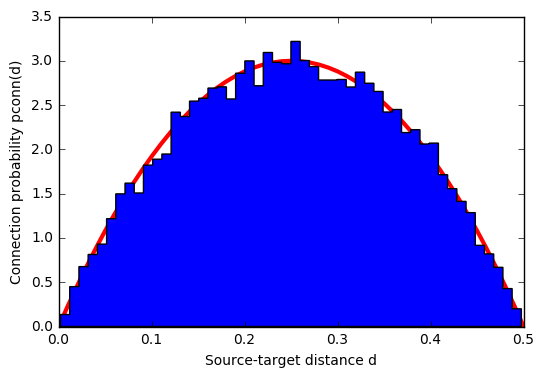

In [21]:
def pn_fig(fig, loc, ldict, cdict,
           xlim=[0., .5], ylim=[0, 3.5], xticks=range(0, 51, 5),
           yticks=np.arange(0., 1.1, 0.2), clr='blue',
           label=''):
    nest.ResetKernel()
    l = tp.CreateLayer(ldict)
    tp.ConnectLayers(l, l, cdict)

    ax = fig.add_subplot(loc)

    rn = nest.GetLeaves(l)[0]
    conns = nest.GetConnections(rn)
    cstat = nest.GetStatus(conns)
    srcs = [sd['source'] for sd in cstat]
    tgts = [sd['target'] for sd in cstat]
    dist = np.array(tp.Distance(srcs, tgts))
    ax.hist(dist, bins=50, histtype='stepfilled', normed=True)
    r = np.arange(0., 0.51, 0.01)

    plt.plot(r, 2 * np.pi * r * (1 - 2 * r) * 12 / np.pi, 'r-', lw=3,
             zorder=-10)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    """ax.set_xticks(xticks)
    ax.set_yticks(yticks)"""
    # ax.set_aspect(100, 'box')
    ax.set_xlabel('Source-target distance d')
    ax.set_ylabel('Connection probability pconn(d)')


fig = plt.figure()

pos = [[np.random.uniform(-1., 1.), np.random.uniform(-1., 1.)]
       for j in range(1000)]
ldict = {'positions': pos, 'extent': [2., 2.],
         'elements': 'iaf_psc_alpha', 'edge_wrap': True}
cdict = {'connection_type': 'divergent',
         'mask': {'circular': {'radius': 1.0}},
         'kernel': {'linear': {'c': 1., 'a': -2., 'cutoff': 0.0}},
         'number_of_connections': 50,
         'allow_multapses': True, 'allow_autapses': False}
pn_fig(fig, 111, ldict, cdict)

Functions determining weight and delay as function of
distance/displacement work in just the same way as before when the
number of connections is prescribed.

## Connecting composite layers
Connections between layers with composite elements are based on the
following principles:

- All nodes within a composite element have the same
  coordinates, the coordinates of the element.
- All nodes within a composite element are treated equally. If,
  e.g., an element of the pool layer contains three nodes and
  connection probability is 1, then connections with all three nodes
  will be created. For probabilistic connection schemes, each of the
  three nodes will be considered individually.
- If only nodes of a given model within each element
  shall be considered as sources or targets then this can be achieved
  by adding a `sources` or `targets` entry to
  the connection dictionary, which specifies the model to connect.

This is exemplified by the following code, which connects pyramidal
cells (`pyr`) to interneurons (`in`) with a
circular mask and uniform probability and interneurons to pyramidal
cells with a rectangular mask unit probability.

In [22]:
nest.ResetKernel()
nest.CopyModel('iaf_psc_alpha', 'pyr')
nest.CopyModel('iaf_psc_alpha', 'in')
ldict = {'rows': 10, 'columns': 10, 'elements': ['pyr', 'in']}
cdict_p2i = {'connection_type': 'divergent',
             'mask': {'circular': {'radius': 0.5}},
             'kernel': 0.8,
             'sources': {'model': 'pyr'},
             'targets': {'model': 'in'}}
cdict_i2p = {'connection_type': 'divergent',
             'mask': {'rectangular': {'lower_left': [-0.2, -0.2],
                                      'upper_right': [0.2, 0.2]}},
             'sources': {'model': 'in'},
             'targets': {'model': 'pyr'}}
l = tp.CreateLayer(ldict)
tp.ConnectLayers(l, l, cdict_p2i)
tp.ConnectLayers(l, l, cdict_i2p)

## Synapse models and properties
By default, `ConnectLayers` creates connections using the
default synapse model in NEST,
`static_synapse`. You can specify a different model by
adding a `synapse_model` entry to the connection
dictionary, as in this example:

In [23]:
nest.ResetKernel()
nest.CopyModel('iaf_psc_alpha', 'pyr')
nest.CopyModel('iaf_psc_alpha', 'in')
nest.CopyModel('static_synapse', 'exc', {'weight': 2.0})
nest.CopyModel('static_synapse', 'inh', {'weight': -8.0})
ldict = {'rows': 10, 'columns': 10, 'elements': ['pyr', 'in']}
cdict_p2i = {'connection_type': 'divergent',
             'mask': {'circular': {'radius': 0.5}},
             'kernel': 0.8,
             'sources': {'model': 'pyr'},
             'targets': {'model': 'in'},
             'synapse_model': 'exc'}
cdict_i2p = {'connection_type': 'divergent',
             'mask': {'rectangular': {'lower_left': [-0.2, -0.2],
                                      'upper_right': [0.2, 0.2]}},
             'sources': {'model': 'in'},
             'targets': {'model': 'pyr'},
             'synapse_model': 'inh'}
l = tp.CreateLayer(ldict)
tp.ConnectLayers(l, l, cdict_p2i)
tp.ConnectLayers(l, l, cdict_i2p)

## Connecting devices to subregions of layers
It is possible to connect stimulation and recording devices only to specific
subregions of layers. A simple way to achieve this is to create a layer
which contains only the device placed typically in its centre.
For connecting the device layer to a neuron layer, an appropriate mask
needs to be specified and optionally also an anchor for shifting the
centre of the mask.
As demonstrated in the following example, stimulation devices require the
divergent and recording devices the convergent connection type:

In [24]:
nrns = tp.CreateLayer({'rows': 20,
                       'columns': 20,
                       'elements': 'iaf_psc_alpha'})

stim = tp.CreateLayer({'rows': 1,
                       'columns': 1,
                       'elements': 'poisson_generator'})

cdict_stim = {'connection_type': 'divergent',
              'mask': {'circular': {'radius': 0.1},
                       'anchor': [0.2, 0.2]}}

tp.ConnectLayers(stim, nrns, cdict_stim)


rec = tp.CreateLayer({'rows': 1,
                      'columns': 1,
                      'elements': 'spike_detector'})

cdict_rec = {'connection_type': 'convergent',
             'mask': {'circular': {'radius': 0.1},
                      'anchor': [-0.2, 0.2]}}

tp.ConnectLayers(nrns, rec, cdict_rec)

# Inspecting Layers
We strongly recommend that you inspect the layers created by Topology
to be sure that node placement and connectivity indeed turned out as
expected. In this chapter, we describe some functions that NEST and
Topology provide to query and visualize networks, layers, and
connectivity.

## Query functions

The following table presents some query functions provided by NEST
(```nest.```) and Topology (```tp.```). For detailed
information about these functions, please see the online Python and
SLI documentation.

<table class="tg" style="border:hidden">
  <tr>
    <td class= style="border:hidden">```nest.PrintNetwork()```</td>
    <td class= style="border:hidden">Print structure of network or subnet from NEST perspective.</td>
  </tr>
  <tr>
    <td class= style="border:hidden">```nest.GetConnections()```</td>
    <td class= style="border:hidden">Retrieve connections (all or for a given source or target); see also [http://www.nest-simulator.org/connection_management](http://www.nest-simulator.org/connection_management).</td>
  </tr>
  <tr>
    <td class= style="border:hidden">```nest.GetNodes()```</td>
    <td class= style="border:hidden">Applied to a layer, returns GIDs of,the layer elements. For simple layers, these are the actual model neurons for composite layers the top-level subnets.</td>
  </tr>
  <tr>
    <td class= style="border:hidden">```nest.GetLeaves()```</td>
    <td class= style="border:hidden">Applied to a layer, returns GIDs of all actual model neurons, ignoring subnets.</td>
  </tr>
  <tr>
    <td class= style="border:hidden">```nest.GetPosition()```</td>
    <td class= style="border:hidden">Return the spatial locations of nodes.</td>
  </tr>
  <tr>
    <td class= style="border:hidden">```nest.GetLayer()```</td>
    <td class= style="border:hidden">Return the layer to which nodes belong.</td>
  </tr>
  <tr>
    <td class= style="border:hidden">```nest.GetElement()```</td>
    <td class= style="border:hidden">Return the node(s) at the location(s) in the given grid-based layer(s).</td>
  </tr>
  <tr>
    <td class= style="border:hidden">```nest.GetTargetNodes()```</td>
    <td class= style="border:hidden">Obtain targets of a list of sources in a given target layer.</td>
  </tr>
  <tr>
    <td class= style="border:hidden">```nest.GetTargetPositions()```</td>
    <td class= style="border:hidden">Obtain positions of targets of a list of sources in a given target layer.</td>
  </tr>
  <tr>
    <td class="tg-yw4l" style="border:hidden">```nest.FindNearestElement()```</td>
    <td class="tg-yw4l" style="border:hidden">Return the node(s) closest to the location(s) in the given layer(s).</td>
  </tr>
  <tr>
    <td class="tg-yw4l" style="border:hidden">```nest.FindCenterElement()```</td>
    <td class="tg-yw4l" style="border:hidden">Return GID(s) of node closest to center of layer(s).</td>
  </tr>
  <tr>
    <td class="tg-yw4l" style="border:hidden">```nest.Displacement()```</td>
    <td class="tg-yw4l" style="border:hidden">Obtain vector of lateral displacement between nodes, taking periodic boundary conditions into account.</td>
  </tr>
  <tr>
    <td class="tg-yw4l" style="border:hidden">```nest.Distance()```</td>
    <td class="tg-yw4l" style="border:hidden">Obtain vector of lateral distances between nodes, taking periodic boundary conditions into account.</td>
  </tr>
  <tr>
    <td class="tg-yw4l" style="border:hidden">```nest.DumpLayerNodes()```</td>
    <td class="tg-yw4l" style="border:hidden">Write layer element positions to file.</td>
  </tr>
  <tr>
    <td class="tg-yw4l" style="border:hidden">```nest.DumpLayerConnections()```</td>
    <td class="tg-yw4l" style="border:hidden">Write connectivity information to file. This function may be very useful to check that Topology created the correct connection structure.</td>
  </tr>
</table>

## Visualization functions
Topology provides three functions to visualize networks:

<table class="tg" style="border:hidden">
  <tr>
    <td class= style="border:hidden">```PlotLayer()```</td>
    <td class= style="border:hidden">Plot nodes in a layer.</td>
  </tr>
  <tr>
    <td class= style="border:hidden">```PlotTargets()```</td>
    <td class= style="border:hidden">Plot all targets of a node in a given layer.</td>
  </tr>
  <tr>
    <td class= style="border:hidden">```PlotKernel()```</td>
    <td class= style="border:hidden">Add indication of mask and kernel to plot of layer. It
    does *not* wrap masks and kernels with respect to periodic
    boundary conditions. This function is usually called by `PlotTargets`.</td>
  </tr>
</table>

The following code shows a practical example: A $21\times21$ network
which connects to itself with divergent Gaussian connections. All
elements and the targets of the centre neuron are shown, as well as
mask and kernel.

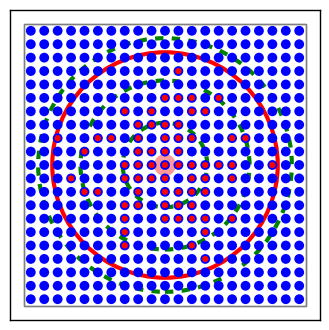

In [25]:
nest.ResetKernel()

l = tp.CreateLayer({'rows': 21, 'columns': 21,
                    'elements': 'iaf_psc_alpha'})
conndict = {'connection_type': 'divergent',
            'mask': {'circular': {'radius': 0.4}},
            'kernel': {'gaussian': {'p_center': 1.0, 'sigma': 0.15}}}
tp.ConnectLayers(l, l, conndict)
fig = plt.figure()
tp.PlotLayer(l, nodesize=50, fig=fig)
ctr = tp.FindCenterElement(l)
tp.PlotTargets(ctr, l, fig=fig,
               mask=conndict['mask'], kernel=conndict['kernel'],
               src_size=250, tgt_color='red', tgt_size=20,
               kernel_color='green')
plt.show()

# Adding topology kernels and masks
This chapter will show examples of how to extend the topology module by
adding custom kernel functions and masks. Some knowledge of the C++
programming language is needed for this. The functions will be added as a
part of an extension module which is dynamically loaded into NEST. For more
information on writing an extension module, see the section titled
[http://nest.github.io/nest-simulator/extension_modules]("Writing an Extension Module")
in the NEST Developer Manual. The basic steps required to get started are:

- From the NEST source directory, copy directory examples/MyModule to
  somewhere outside the NEST source, build or install directories.
- Change to the new location of MyModule and prepare by issuing
  `./bootstrap.sh`
- Leave MyModule and create a build directory for it, e.g., mmb next to
  it
    
```bash
cd ..
mkdir mmb
cd mmb
```

- Configure. The configure process uses the script `nest-config`
  to find out where NEST is installed, where the source code resides, and
  which compiler options were used for compiling NEST. If
  `nest-config` is not in your path, you need to provided it
  explicitly like this

```bash
cmake -Dwith-nest=${NEST_INSTALL_DIR}/bin/nest-config ../MyModule
```

- MyModule will then be installed to `${NEST_INSTALL_DIR}`. This
  ensures that NEST will be able to find initializing SLI files for the
  module.  You should not use the `--prefix`to select a different
  installation destination. If you do, you must make sure to use `addpath` in
  SLI before loading the module to ensure that NEST will find the SLI
  initialization file for your module.
- Compile.

```bash
make
make install
```

The last command installed MyModule to the NEST installation directory, including help files generated from the source code. 

## Adding kernel functions

As an example, we will add a kernel function called `affine2d`,
which will be linear (actually affine) in the displacement of the nodes, on
the form
\begin{equation*}
  p(d) = a d_x + b d_y + c.
\end{equation*}
The kernel functions are provided by C++ classes subclassed from
`nest::Parameter`. To enable subclassing, add the following lines
at the top of the file `mymodule.h`:
```C++
#include "topologymodule.h"
#include "parameter.h"
```
Then, add the class definition, e.g. near the bottom of the file before the
brace closing the namespace `mynest`:
```C++ 
class Affine2DParameter : public nest::Parameter
 {
 public:
  Affine2DParameter(const DictionaryDatum& d)
  : Parameter(d)
  , a_(1.0)
  , b_(1.0)
  , c_(0.0)
  {
    updateValue<double>(d, "a", a_);
    updateValue<double>(d, "b", b_);
    updateValue<double>(d, "c", c_);
  }

  double raw_value(const nest::Position<2>& disp, librandom::RngPtr&) const 
  {
    return a_ * disp[0] + b_ * disp[1] + c_;
  }

  nest::Parameter* clone() const 
  { 
    return new Affine2DParameter(*this);
  }

 private:
  double a_, b_, c_;
};
```

The class contains a constructor, which reads the value of the parameters
$a$, $b$ and $c$ from the dictionary provided by the user. The function
`updateValue` will do nothing if the given key is not in the
dictionary, and the default values $a=b=1,\ c=0$ will be used.

The overridden method `raw_value()` will return the actual value
of the kernel function for the displacement given as the first argument,
which is of type `nest::Position<2>`. The template argument 2
refers to a 2-dimensional position. You can also implement a method taking
a `nest::Position<3>` as the first argument if you want to
support 3-dimensional layers. The second argument, a random number
generator, is not used in this example.

The class also needs to have a `clone()` method, which will return
a dynamically allocated copy of the object. We use the (default) copy
constructor to implement this.

To make the custom function available to the Topology module, you need to
register the class you have provided. To do this, add the line
```C++
nest::TopologyModule::register_parameter<Affine2DParameter>("affine2d");
```
to the function `MyModule::init()` in the file
`mymodule.cpp`. Now compile and install the module by issuing
```bash
make
make install
```

To use the function, the module must be loaded into NEST using
`nest.Install()`. Then, the function is
available to be used in connections, e.g. 
```python
nest.Install('mymodule')
l = tp.CreateLayer({'rows': 11, 'columns': 11, 'extent': [1.,1.],
                        'elements': 'iaf_psc_alpha'})
tp.ConnectLayers(l,l,{'connection_type': 'convergent',
            'mask': {'circular': {'radius': 0.5}},
            'kernel': {'affine2d': {'a': 1.0, 'b': 2.0, 'c': 0.5}}})
```

## Adding masks

The process of adding a mask is similar to that of adding a kernel
function. A subclass of ```nest::Mask<D>``` must be defined, where
`D` is the dimension (2 or 3). In this case we will define a
2-dimensional elliptic mask by creating a class called
`EllipticMask`. First, we must include another header file:
```C++
#include "mask.h"
```
Compared to the `Parameter` class discussed in the previous
section, the `Mask` class has a few more methods that must be
overridden:
```C++
class EllipticMask : public nest::Mask<2>
{
 public:
  EllipticMask(const DictionaryDatum &d) : rx_(1.0), ry_(1.0)
  {
    updateValue<double>(d, "r_x", rx_);
    updateValue<double>(d, "r_y", ry_);
  }

  using Mask<2>::inside;

  // returns true if point is inside the ellipse
  bool inside(const nest::Position<2> &p) const
  {
    return p[0] * p[0] / rx_ / rx_ + p[1] * p[1] / ry_ / ry_ <= 1.0;
  }

  // returns true if the whole box is inside the ellipse
  bool inside(const nest::Box<2> &b) const
  {
    nest::Position<2> p = b.lower_left;

    // Test if all corners are inside mask
    if (not inside(p)) return false;  // (0,0)
    p[0] = b.upper_right[0];
    if (not inside(p)) return false;  // (0,1)
    p[1] = b.upper_right[1];
    if (not inside(p)) return false;  // (1,1)
    p[0] = b.lower_left[0];
    if (not inside(p)) return false;  // (1,0)

    return true;
  }

  // returns bounding box of ellipse
  nest::Box<2> get_bbox() const
  {
    nest::Position<2> ll(-rx_, -ry_);
    nest::Position<2> ur(rx_, ry_);
    return nest::Box<2>(ll, ur);
  }

  nest::Mask<2> *clone() const { return new EllipticMask(*this); }

 protected:
  double rx_, ry_;
};
```
The overridden methods include a test if a point is inside the mask, and
for efficiency reasons also a test if a box is fully inside the mask. We
implement the latter by testing if all the corners are inside, since our
elliptic mask is convex. We must also define a function which returns a
bounding box for the mask, i.e. a box completely surrounding the mask.

Similar to kernel functions, the mask class must be registered with the
topology module, and this is done by adding a line to the function
`MyModule::init()` in the file `mymodule.cpp`:
```C++
    nest::TopologyModule::register_mask<EllipticMask>("elliptic");
```
After compiling and installing the module, the mask is available to be used
in connections, e.g.
```python
nest.Install('mymodule')
l = tp.CreateLayer({'rows': 11, 'columns': 11, 'extent': [1.,1.],
                        'elements': 'iaf_psc_alpha'})
tp.ConnectLayers(l,l,{'connection_type': 'convergent',
            'mask': {'elliptic': {'r_x': 0.5, 'r_y': 0.25}}})
```


# Changes from Topology 2.0 to 2.2

This is a short summary of the most important changes in the Topology
Module from NEST version 2.0 to 2.2.

- Nested layers are no longer supported.
- Subnets are no longer used inside composite layers. A call to
  GetElement for a composite layer will now return a list of GIDs for the
  nodes at the position rather than a single subnet GID.
- Positions in layers may now be 3-dimensional.
- The functions GetPosition, Displacement and Distance now only works
  for nodes local to the current MPI process, if used in a MPI-parallel
  simulation.
- It is now possible to add kernel functions and masks to the Topology
  module through an extension module.

# Changes from Topology 1.9 to 2.0

This is a short summary of the most important changes in the NEST
Topology Module from the 1.9-xxxx to the 2.0 version.

- ConnectLayer is now called ConnectLayers
- Several other functions changed names, and there are many new
  functions.
- All nest.topology functions now require lists of GIDs as input,
  not "naked" GIDs
- There are a number of new functions in nest.topology, I tried to
  write good doc strings for them
- For grid based layers (ie those with /rows and /columns), we
  have changed the definition of "extent": Previously, nodes were
  placed on the edges of the extent, so if you had an extend of 2 (in
  x-direction) and 3 nodes, these had x-coordinates -1, 0, 1. The grid
  constant was extent/(num\_nodes - 1).

  Now, we define the grid constant as extent/num\_nodes, centre the
  nodes about 0 and thus add a space of half a grid constant between
  the outermost nodes and the boundary of the extent. If you want
  three nodes at -1,0,1 you thus have to set the extent to 3, i.e.,
  stretching from -1.5 to 1.5.

  The main reason for this change was that topology always added this
  padding silently when you used periodic boundary conditions
  (otherwise, neurons are the left and right edge would have been in
  identical locations, not what one wants).
- The semantics of the `anchor` entry for kernel
  functions has changed: the anchor now specifies the centre of the
  probability distribution relative to the driver node. This is
  consistent with the semantics for free masks.
- Functions computing connection probabilities, weights and delays
  as functions of distance between source and target nodes now handle
  periodic boundary conditions correctly.
- Masks with a diameter larger than the diameter of the layer they
  are applied to are now prohibited by default. This avoids multiple
  connections when masks overwrap.


# References
Jochen Martin Eppler, Moritz Helias, Eilif Muller, Markus Diesmann, and Marc-Oliver
Gewaltig. PyNEST: A convenient interface to the NEST simulator. Front Neuroinformatics, 2:12, 2008. doi: 10.3389/neuro.11.012.2008.

M.-O. Gewaltig and M. Diesmann. Nest (neural simulation tool). Scholarpedia, 2(4): 1430, 2007. 

Eilen Nordlie, Marc-Oliver Gewaltig, and Hans Ekkehard Plesser. Towards reproducible descriptions of neuronal network models. PLoS Comput Biol, 5(8):e1000456, Aug 2009. doi:10.1371/journal.pcbi.1000456.